# Importing libraries

In [1]:
!pip install --upgrade pip
!pip install torchmetrics
!pip install scikit-image
!pip install pycocotools
!pip install matplotlib
!pip install pytorch
!pip install torchvision
!pip install opencv-python
!pip install transformers
!apt-get install -y libgl1

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pytorch (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      Traceback (most recent call last):
        File "/opt/jupyter_venv/lib/python3.10/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
          main()
        File "/opt/jupyter_venv/lib/python3.10/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
        File "/opt/jupyter_venv/lib/python3.10/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 251, in build_wheel
          return _build_backend().build_wheel(wheel_directory, config_settings,
        File "/tmp/pip-build-env-b_324

In [2]:
from pycocotools.coco import COCO
import json
# for plotting
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from IPython.display import clear_output

import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics import JaccardIndex
from torchmetrics.detection import IntersectionOverUnion
from torchmetrics.functional.detection import intersection_over_union
import transformers


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [93]:
def calc_instersection_over_union(preds, targets):
  loss = []
  for pred, targett in zip(preds, target):
    pred_boxes = pred['boxes']
    pred_labels = pred['labels']
    target_boxes = targett['boxes']
    target_labels = targett['labels']

    pred_x_start = pred_boxes[..., 0]
    pred_x_end = pred_boxes[..., 0] + pred_boxes[..., 2]
    pred_y_start = pred_boxes[..., 1]
    pred_y_end = pred_boxes[..., 1] + pred_boxes[..., 3]

    target_x_start = target_boxes[..., 0]
    target_x_end = target_boxes[..., 0] + target_boxes[..., 2]
    target_y_start = target_boxes[..., 1]
    target_y_end = target_boxes[..., 1] + target_boxes[..., 3]

    if_intersect = (pred_x_start < target_x_end).float() * (pred_x_end > target_x_start).float() * (pred_y_start < target_y_end).float() * (pred_y_end > target_y_start).float()

    union_x_start = torch.max(pred_x_start, target_x_start)
    union_x_end = torch.min(pred_x_end, target_x_end)
    union_y_start = torch.max(pred_y_start, target_y_start)
    union_y_end = torch.min(pred_y_end, target_y_end)

    intersection_area = (union_x_end - union_x_start) * (union_y_end - union_y_start)
    pred_area = (pred_x_end - pred_x_start) * (pred_y_end - pred_y_start)
    target_area = (target_x_end - target_x_start) * (target_y_end - target_y_start)

    iou = (if_intersect *
     (intersection_area / (pred_area + target_area - intersection_area)))

    loss.append(iou)
  return iou



# plotting moving average
def calc_mov_average(arr, window_len=300):
    # Handle edge case where window_len is greater than the length of the array
    if window_len <= 1:
        return arr  # No moving average needed if window length is 1 or less

    # Array to store the moving averages
    result = np.zeros_like(arr)

    # Loop over the array and compute the moving average
    for i in range(len(arr)):
        # Define the window start and end indices
        start = max(0, i - window_len + 1)
        end = i + 1

        # Compute the mean for the window, handles fewer elements than window_len
        result[i] = np.mean(arr[start:end])

    return result

# Custom function to printing
def print_image_cv(image, bboxs=None, center_bboxs=None, color=(0, 255, 0)):
    image = np.asarray(image)
    if np.max(image)<=1:
        image = image * 255
    if image.shape[0]==3:
        image = np.transpose(image, (1, 2, 0))
    image = image.astype(np.uint8)
    bgr_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    #image = cv2.imread(I)
    thickness = 2  # Thickness of the rectangle border
    if bboxs is not None:
        for bbox in bboxs:
          bbox = np.asarray(bbox)
          cv2.rectangle(bgr_image,
          (int(bbox[0]), int(bbox[1])),
          (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])),
                        color,
                        thickness)
    if center_bboxs is not None:
        for center_bbox in center_bboxs:
          center_bbox = np.asarray(center_bbox)
          center_bbox = (int(center_bbox[0]), int(center_bbox[1]))
          cv2.circle(bgr_image, center_bbox, 2, color, -1)

    bgr_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    plt.imshow(bgr_image)
    plt.show()
    plt.close()


  # Custom collate function to dataloader
def collate_fn(batch):
  # Here we are using the default collate_fn for most parts,
  # but you can handle the padding of bounding boxes here if necessary.
  images = []
  boxes = []
  labels = []
  height_scale = []
  width_scale = []
  center_bboxs = []
  output_to_rpn = []
  i = 0
  for sample in batch:
      images.append(sample['image'])
      boxes.append(sample['bbox'])
      c_b = sample['center_bbox']
      pom = torch.ones(c_b.shape[0]).unsqueeze(-1) * i
      c_b = torch.cat((pom, c_b), 1)
      center_bboxs.append(c_b)
      labels.append(sample['category_id'])
      height_scale.append(sample['height_scale'])
      width_scale.append(sample['width_scale'])
      output_to_rpn.append(sample['output_to_rpn'])
      i += 1

  # You can optionally stack images to form a batch
  images = torch.stack(images, dim=0)  # Assuming all images are of the same size after transformation
  height_scale = torch.stack(height_scale, dim=0)
  width_scale = torch.stack(width_scale, dim=0)
  #center_bboxs = torch.stack(center_bboxs, dim=0)
  output_to_rpn = torch.stack(output_to_rpn, dim=0)
  center_bboxs = torch.cat(center_bboxs, dim=0)

  # You can pad boxes or labels here if necessary, or leave them as lists (which works with collate_fn)
  return {'image': images,
          'bboxes': boxes,
          'center_bboxs': center_bboxs,
          'category_id': labels,
          'height_scale': height_scale,
          'width_scale': width_scale,
          'output_to_rpn': output_to_rpn}

# prepare bounding boxes
def prepare_pred_bbox(anchors_output, center_pixel, anchors, patch_size, new_size):
    # xywh
    moved_centers = center_pixel.unsqueeze(1) + anchors_output[:, :, :2] * patch_size
    pred_bbox = torch.zeros_like(anchors_output)

    # Avoid in-place assignment
    pred_bbox[:, :, 0] = (moved_centers[:, :, 0] - anchors[:, 0] / 2 * F.relu(1 + anchors_output[:, :, 2])).clone()
    pred_bbox[:, :, 1] = (moved_centers[:, :, 1] - anchors[:, 1] / 2 * F.relu(1 + anchors_output[:, :, 3])).clone()
    pred_bbox[:, :, 2] = (anchors[:, 0] * F.relu(1 + anchors_output[:, :, 2])).clone()
    pred_bbox[:, :, 3] = (anchors[:, 1] * F.relu(1 + anchors_output[:, :, 3])).clone()

    pred_bbox = F.relu(pred_bbox).clone()  # Avoid modifying pred_bbox in-place
    pred_bbox[:, :, 0] = pred_bbox[:, :, 0].clone().clip(0, new_size[0])
    pred_bbox[:, :, 1] = pred_bbox[:, :, 1].clone().clip(0, new_size[1])
    pred_bbox[:, :, 2] = pred_bbox[:, :, 2].clone() - F.relu(pred_bbox[:, :, 0] + pred_bbox[:, :, 2] - new_size[0])
    pred_bbox[:, :, 3] = pred_bbox[:, :, 3].clone() - F.relu(pred_bbox[:, :, 1] + pred_bbox[:, :, 3] - new_size[1])

    return pred_bbox

  # Dataset class
class ImageDataset(Dataset):
  def __init__(self, coco, catnms, patch_size, new_size, transform=None):
    super(ImageDataset, self).__init__()
    self.coco = coco
    self.transform = transforms.Compose(transform)
    catIds = coco.getCatIds(catNms=catnms)
    self.catIds = catIds[:100]
    imgIds = coco.getImgIds(catIds=catIds)
    self.imgIds = imgIds[:100]
    self.new_size = new_size
    self.patch_size = patch_size
    #annIds = coco.getAnnIds(imgIds=imgIds, catIds=catIds, iscrowd=None)
    #anns = coco.loadAnns(annIds)

  def __len__(self):
    return len(self.imgIds)

  def __getitem__(self, idx):
    imgId = self.imgIds[idx]
    annIds = self.coco.getAnnIds(imgIds=imgId, catIds=self.catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    image_data = self.coco.loadImgs(imgId)[0]
    height = image_data['height']
    width = image_data['width']
    image_link = image_data['coco_url']
    image = io.imread(image_link)
    image = self.transform(image)
    bbox = [x['bbox'] for x in anns]
    category_id = [x['category_id'] for x in anns]
    bbox = torch.tensor(bbox)
    width_scale = self.new_size[1] / width
    height_scale = self.new_size[0] / height
    bbox[:, 0] = bbox[:, 0] * width_scale
    bbox[:, 1] = bbox[:, 1] * height_scale
    bbox[:, 2] = bbox[:, 2] * width_scale
    bbox[:, 3] = bbox[:, 3] * height_scale

    center_bbox = torch.zeros((bbox.shape[0], 2))
    center_bbox[:, 0] = bbox[:, 0] + bbox[:, 2] / 2
    center_bbox[:, 1] = bbox[:, 1] + bbox[:, 3] / 2

    output_to_rpn = torch.zeros((self.new_size[0] // self.patch_size, self.new_size[1] // self.patch_size))
    output_to_rpn[(center_bbox // self.patch_size).int()[:, 0],(center_bbox // self.patch_size).int()[:, 1]] = 1

    return {'image': image,
            'bbox': bbox,
            'center_bbox': center_bbox,
            'category_id': torch.tensor(category_id),
            'height_scale': torch.tensor(height_scale, dtype=torch.float32),
            'width_scale': torch.tensor(width_scale, dtype=torch.float32),
            'output_to_rpn': output_to_rpn}

# class for resnet model
class ResNetModel(nn.Module):
  def __init__(self, resnet_config, device='cpu'):
    super(ResNetModel, self).__init__()
    self.baseline = transformers.ResNetModel(resnet_config).to(device)
    self.lin1 = nn.Linear(resnet_config.hidden_sizes[-1],
                                1024,
                                device=device)
    self.output_rpn = nn.Linear(1024,
                                1,
                                device=device)

  def forward(self, x):
    last_hidden_state, _ = self.baseline(x, return_dict=False)
    last_hidden_state = last_hidden_state.permute(0, 2, 3, 1)
    # last_hidden_state = output['last_hidden_state']
    x = self.lin1(last_hidden_state)
    x = F.gelu(x)
    rpn_output = self.output_rpn(x)
    return rpn_output, last_hidden_state

# class for second stage model
class SecondStageModel(nn.Module):
  def __init__(self, hidden_dim, num_anchors, num_classes, device='cpu'):
    super(SecondStageModel, self).__init__()
    self.num_anchors = num_anchors
    self.num_classes = num_classes
    self.output_anchor_coordinates = nn.Linear(hidden_dim, 4 * num_anchors, device=device)
    self.output_classes = nn.Linear(hidden_dim, num_classes * num_anchors, device=device)
  def forward(self, x):
    output_anchor = self.output_anchor_coordinates(x)
    output_classes = self.output_classes(x)
    return output_anchor.reshape(-1, self.num_anchors, 4), output_classes.reshape(-1, self.num_anchors, self.num_classes)

# Intersect o

# Download data

In [4]:
!mkdir ./annotations
!wget -P ./annotations/ http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
!wget -P ./annotations/ http://images.cocodataset.org/annotations/annotations_trainval2017.zip

!unzip ./annotations/stuff_annotations_trainval2017.zip
!unzip ./annotations/annotations_trainval2017.zip

dataDir='.'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

mkdir: cannot create directory ‘./annotations’: File exists
--2024-12-17 11:30:06--  http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.230.113, 52.217.125.161, 52.217.160.81, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.230.113|:80... connected.
200 OKequest sent, awaiting response... 
Length: 1148688564 (1.1G) [application/zip]
Saving to: ‘./annotations/stuff_annotations_trainval2017.zip.1’

stuff_annotations_t 100%[===================>]   1.07G  54.3MB/s    in 18s     

2024-12-17 11:30:24 (60.2 MB/s) - ‘./annotations/stuff_annotations_trainval2017.zip.1’ saved [1148688564/1148688564]

--2024-12-17 11:30:24--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.64.204, 54.231.232.169, 3.5.11.187, ...
connected. to images.cocodataset.org (images.cocodataset.org)|52.217.64.204|:8

# Initiate API and analysis

In [6]:
# Initiate API
coco=COCO(annFile)

loading annotations into memory...
Done (t=8.37s)
creating index...
index created!


In [7]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush



In [8]:
# Take examples of data
catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds )
#imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds)
print(len(img))

64115


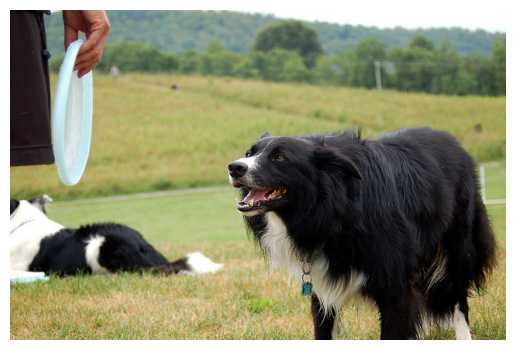

In [9]:
# Print one image
I = io.imread(img[2]['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()
plt.close()

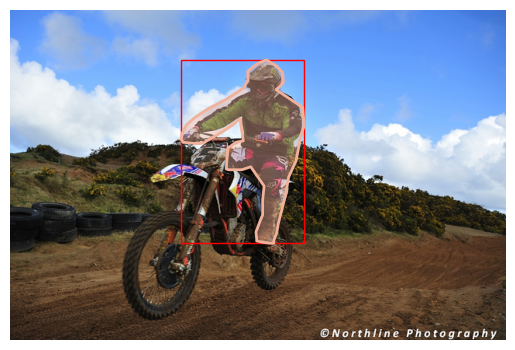

In [10]:
# Print image with bbox and map
number = 8
I = io.imread(img[number]['coco_url'])
fig, ax = plt.subplots()
ax.imshow(I)
ax.axis('off')

annIds = coco.getAnnIds(imgIds=img[number]['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

bbox = anns[0]['bbox']
rect = patches.Rectangle(bbox[:2], bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
coco.showAnns(anns)

(426, 640, 3)


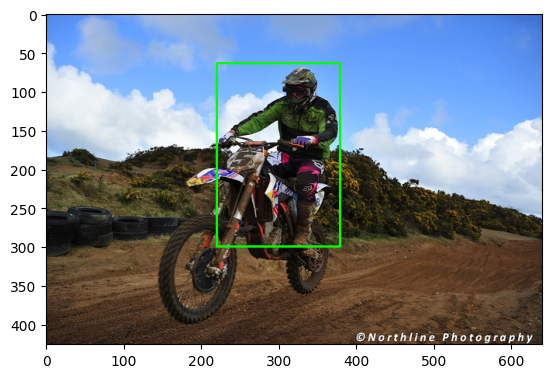

In [11]:
# Check if function is working
I = io.imread(img[number]['coco_url'])
print(I.shape)
print_image_cv(I, [bbox, ])

# Create dataset and dataloader

In [94]:
new_size = (512, 512)
patch_size = 512 // 16
transform = [transforms.ToTensor(),
             transforms.Lambda(lambda img: img.repeat(3//img.shape[0], 1, 1)),
             transforms.Resize(new_size)]
person_dataset = ImageDataset(coco, ['person'], patch_size, new_size, transform)

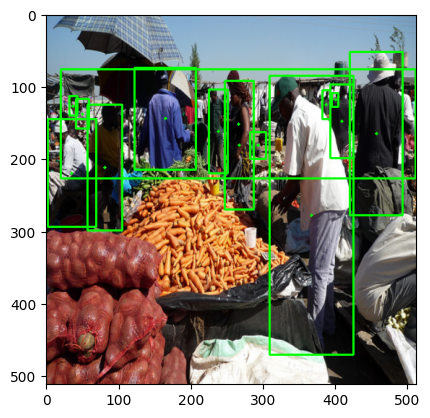

In [95]:
# print example of dataset
num = 0
print_image_cv(person_dataset[num]['image'], person_dataset[num]['bbox'], person_dataset[num]['center_bbox'])

In [96]:
import multiprocessing
print(multiprocessing.cpu_count())

12


In [97]:
# define dataloader
BATCH_SIZE = 16
dataloader = DataLoader(person_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=12)

In [98]:
# validate results
test_data = next(iter(dataloader))
for key, value in test_data.items():
  print(key, type(value))
  if isinstance(value, torch.Tensor):
    print(value.shape)

image <class 'torch.Tensor'>
torch.Size([16, 3, 512, 512])
bboxes <class 'list'>
center_bboxs <class 'torch.Tensor'>
torch.Size([77, 3])
category_id <class 'list'>
height_scale <class 'torch.Tensor'>
torch.Size([16])
width_scale <class 'torch.Tensor'>
torch.Size([16])
output_to_rpn <class 'torch.Tensor'>
torch.Size([16, 16, 16])


# define models

In [99]:
# create anchors
#anchor_sizes = [16, 32, 64]
#anchor_ratios = [(1, 1), (2, 1), (1, 2)]
anchor_sizes = [32, ]
anchor_ratios = [(1, 1), ]
anchors = []
for size in anchor_sizes:
  for ratio in anchor_ratios:
    anchors.append((size * ratio[0], size * ratio[1]))
anchors = torch.tensor(anchors).to(device)
print(anchors)

tensor([[32, 32]], device='cuda:0')


In [104]:
resnet_config = transformers.ResNetConfig(num_channels=3,
                                          embedding_size=64,
                                          #hidden_sizes=(64, 128, 256, 512, 1024),
                                          hidden_act='gelu',
                                          #depths = [3, 3, 3, 3, 3, 3],
                                          device = device)

resnet_model = ResNetModel(resnet_config,
                           device = device)
second_stage_model = SecondStageModel(resnet_config.hidden_sizes[-1], len(anchors), 2, device=device)

# resnet_model

In [105]:
# test if model is working
with torch.no_grad():
  resnet_model.eval()
  rpn_output, first_stage_output = resnet_model(test_data['image'].to(device))
  print(rpn_output.shape, first_stage_output.shape)

  second_stage_model.eval()
  second_stage_output = second_stage_model(first_stage_output[:, 0, 0])
  print(second_stage_output[0].shape, second_stage_output[1].shape)

torch.Size([16, 16, 16, 1]) torch.Size([16, 16, 16, 2048])
torch.Size([16, 1, 4]) torch.Size([16, 1, 2])


# define functions for training

In [106]:
pos_weight = torch.tensor([16, ]).to(device)
loss_fn_rpn = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='sum')#nn.CrossEntropyLoss(reduce='sum')
loss_fn_bbox = IntersectionOverUnion(box_format='xywh',
                                     # respect_labels=False
                                     )
resnet_optimizer = optim.AdamW(resnet_model.parameters(), lr=2e-4)
second_stage_optimizer = optim.AdamW(second_stage_model.parameters(), lr=1e-3)

resnet_scheduler = transformers.get_linear_schedule_with_warmup(optimizer=resnet_optimizer,
                                                                num_warmup_steps=3000,
                                                                num_training_steps=100000)

#second_stage_scheduler = transformers.get_linear_schedule_with_warmup(optimizer=second_stage_optimizer,
#                                                                num_warmup_steps=1000,
#                                                                num_training_steps=10000)

# training

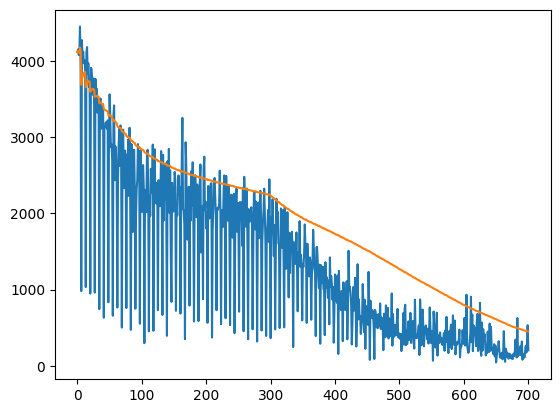

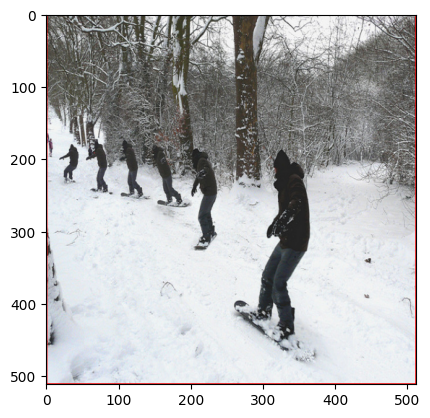

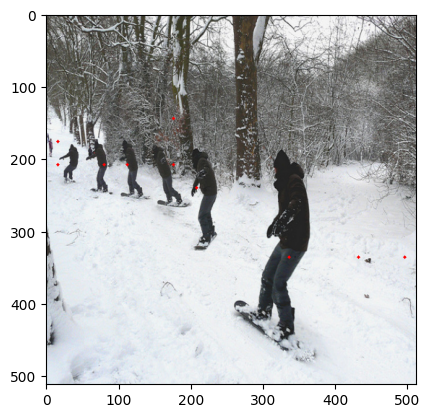

In [ ]:
epochs = int(10**5)
if_train_second_stage = True
if_train_first_stage = True
if if_train_first_stage:
  resnet_model.train()
else:
  resnet_model.eval()
if if_train_second_stage:
  second_stage_model.train()
else:
  second_stage_model.eval()
second_stage_model.train()
gc.collect()
torch.cuda.empty_cache()
step = 0
step_show = 35
losses = []
for epoch in range(epochs):
  for data in dataloader:
    loss = 0
    resnet_optimizer.zero_grad()
    if if_train_second_stage: second_stage_optimizer.zero_grad()
    image_data = data['image'].to(device)
    temp_bs = len(image_data)

    # calculate loss for rpn)
    target_rpn = data['output_to_rpn'].to(device)
    rpn_output, first_stage_output = resnet_model(image_data)

    if if_train_first_stage:
      loss_rpn = loss_fn_rpn(rpn_output, target_rpn.unsqueeze(-1))
    #loss_rpn.backward()


    # extract first stage output parameters only for patches which contain object
    # first collect the indices of patches

    # then extract features
    if if_train_second_stage:
      center = data['center_bboxs'].to(device)
      center[:, 1:] = center[:, 1:] // patch_size
      center = center.long()
      features = first_stage_output[center[:, 0], center[:, 1], center[:, 2]]
      features = features.view(-1, resnet_config.hidden_sizes[-1])

    # apply second stage model to features
      anchors_output, classes_output = second_stage_model(features)

    # calculate predicted bounding boxes
      center_pixel = center[:, 1:] * patch_size + patch_size // 2
      predicted_bboxes = prepare_pred_bbox(anchors_output, center_pixel, anchors, patch_size, new_size)
    #calculate iou loss
      preds = [
          {'boxes': predicted_bboxes.view(-1, 4),
          'labels': classes_output.argmax(-1).view(-1, )},
      ]
      target_bboxes = torch.cat(data['bboxes'], dim=0).unsqueeze(1).repeat(1, len(anchors), 1).view(-1, 4).to(device)
      target_labels = torch.cat(data['category_id'], dim=0).unsqueeze(1).repeat(1, len(anchors), 1).view(-1, ).to(device)
      target = [
          {'boxes': target_bboxes,
          'labels': target_labels},
      ]
      iou_loss = loss_fn_bbox(preds, target)
    if if_train_first_stage:
      loss = loss + loss_rpn
    if if_train_second_stage:
      loss = loss - iou_loss['iou'].sum() * len(anchors) * 100
    loss.backward()
    if if_train_second_stage:
      second_stage_optimizer.step()
      #second_stage_scheduler.step()
    if if_train_first_stage:
      resnet_optimizer.step()
      resnet_scheduler.step()
    losses.append(loss.item())

    if step % step_show ==0:
        clear_output(wait=True)
        #print(F.sigmoid(rpn_output[0]).squeeze().detach().cpu().numpy().round(2))
        fig, ax1 = plt.subplots()
        ax1.plot(losses)
        y_to_plot = calc_mov_average(losses)
        ax1.plot(y_to_plot)
        #ax1.set_ylim([0, np.max(y_to_plot[-500:]) * 1.5])
        plt.show()
        plt.close()
        if if_train_second_stage:
            print_image_cv(data['image'].cpu()[0], preds[0]['boxes'].detach().cpu()[:len(anchors)], color=(0, 0, 255))
        if if_train_first_stage:
            indices = torch.nonzero(F.sigmoid(rpn_output[0].detach()).cpu() > 0.5)
            print_image_cv(data['image'].cpu()[0], center_bboxs=indices[..., :2] * patch_size + patch_size//2, color=(0, 0, 255))
        print_image_cv(data['image'].cpu()[0],
                    data['bboxes'][0],
                    center_bboxs=data['center_bboxs'][torch.where(data['center_bboxs'][:, 0]==0.)][:, 1:].int(), color=(0, 255, 0))
        gc.collect()
    print(f"Epoch: {epoch}, step: {step}, loss: {loss}"
    # iou {iou_loss['iou'].sum()}\
    )
    #del features, anchors_output, classes_output, predicted_bboxes, preds
    torch.cuda.empty_cache()

    step += 1
    #if step > 0:
    #  break


